<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/test/cox_ph_and_deepsurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torchtuples
!pip install pycox

     |████████████████████████████████| 81kB 4.0MB/s 


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [7]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [8]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Dataset 'metabric' not locally available. Downloading...


/usr/local/lib/python3.6/dist-packages/pycox/datasets/from_deepsurv.py:26: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


Done


In [9]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [10]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [11]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [12]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

In [13]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

In [14]:
model = CoxPH(net, tt.optim.Adam)

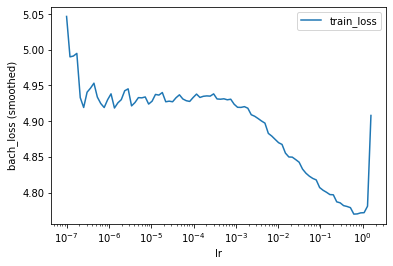

In [15]:

batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [16]:
lrfinder.get_best_lr()

0.0613590727341321

In [17]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [18]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7805,	val_loss: 3.9704
1:	[0s / 0s],		train_loss: 4.6663,	val_loss: 4.0426
2:	[0s / 0s],		train_loss: 4.6195,	val_loss: 3.9074
3:	[0s / 0s],		train_loss: 4.5979,	val_loss: 3.9429
4:	[0s / 0s],		train_loss: 4.5847,	val_loss: 3.9162
5:	[0s / 0s],		train_loss: 4.5572,	val_loss: 3.9225
6:	[0s / 0s],		train_loss: 4.5611,	val_loss: 3.9255
7:	[0s / 0s],		train_loss: 4.5508,	val_loss: 3.9290
8:	[0s / 0s],		train_loss: 4.5577,	val_loss: 3.9557
9:	[0s / 0s],		train_loss: 4.5578,	val_loss: 3.8967
10:	[0s / 0s],		train_loss: 4.5475,	val_loss: 3.9598
11:	[0s / 0s],		train_loss: 4.5447,	val_loss: 3.9310
12:	[0s / 0s],		train_loss: 4.5320,	val_loss: 3.9501
13:	[0s / 0s],		train_loss: 4.5621,	val_loss: 3.9553
14:	[0s / 0s],		train_loss: 4.5479,	val_loss: 3.9061
15:	[0s / 0s],		train_loss: 4.5371,	val_loss: 3.9465
16:	[0s / 0s],		train_loss: 4.5041,	val_loss: 3.9648
17:	[0s / 0s],		train_loss: 4.5735,	val_loss: 3.9840
18:	[0s / 0s],		train_loss: 4.5601,	val_loss: 3.9561
19:

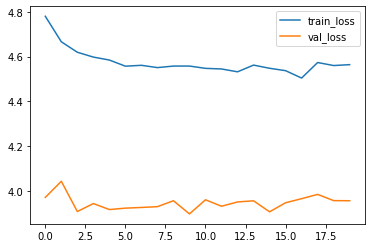

In [19]:
_ = log.plot()

In [20]:
model.partial_log_likelihood(*val).mean()

-4.982344627380371

In [21]:
_ = model.compute_baseline_hazards()

In [38]:
x_test[[0]]

array([[-0.7876059 ,  2.3557053 ,  0.05270737,  2.2646382 ,  1.4492289 ,
         0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

In [39]:
surv = model.predict_surv_df(x_test[[0]])

In [41]:
surv.shape

(1128, 1)

In [33]:
surv

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380
duration,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.100000,0.999125,0.999710,0.999452,0.999341,0.998469,0.999662,0.999745,0.999845,0.998300,9.980245e-01,0.999574,0.998917,0.998556,0.999491,0.999337,0.998444,0.999392,0.998586,0.998734,0.999703,0.999795,9.981591e-01,0.999788,0.999080,9.960631e-01,0.998409,0.999382,0.998723,0.999737,0.999474,0.999592,0.999544,0.999329,0.998605,0.999255,0.999546,0.999546,0.999748,0.999415,0.999447,...,0.999328,0.999731,0.999728,0.999811,0.999074,0.999888,0.999362,0.998947,0.998948,9.973809e-01,0.999605,0.998592,9.972476e-01,0.999407,0.999815,0.999201,0.998328,0.999516,0.999211,0.999400,0.999283,0.999490,0.999293,0.999671,0.999444,0.999515,0.999842,0.999448,0.999195,0.999274,0.999441,9.980302e-01,0.999255,0.999842,0.999368,0.999301,0.998792,0.998454,0.999680,9.981791e-01
0.766667,0.999125,0.999710,0.999452,0.999341,0.998469,0.999662,0.999745,0.999845,0.998300,9.980245e-01,0.999574,0.998917,0.998556,0.999491,0.999337,0.998444,0.999392,0.998586,0.998734,0.999703,0.999795,9.981591e-01,0.999788,0.999080,9.960631e-01,0.998409,0.999382,0.998723,0.999737,0.999474,0.999592,0.999544,0.999329,0.998605,0.999255,0.999546,0.999546,0.999748,0.999415,0.999447,...,0.999328,0.999731,0.999728,0.999811,0.999074,0.999888,0.999362,0.998947,0.998948,9.973809e-01,0.999605,0.998592,9.972476e-01,0.999407,0.999815,0.999201,0.998328,0.999516,0.999211,0.999400,0.999283,0.999490,0.999293,0.999671,0.999444,0.999515,0.999842,0.999448,0.999195,0.999274,0.999441,9.980302e-01,0.999255,0.999842,0.999368,0.999301,0.998792,0.998454,0.999680,9.981791e-01
1.233333,0.999125,0.999710,0.999452,0.999341,0.998469,0.999662,0.999745,0.999845,0.998300,9.980245e-01,0.999574,0.998917,0.998556,0.999491,0.999337,0.998444,0.999392,0.998586,0.998734,0.999703,0.999795,9.981591e-01,0.999788,0.999080,9.960631e-01,0.998409,0.999382,0.998723,0.999737,0.999474,0.999592,0.999544,0.999329,0.998605,0.999255,0.999546,0.999546,0.999748,0.999415,0.999447,...,0.999328,0.999731,0.999728,0.999811,0.999074,0.999888,0.999362,0.998947,0.998948,9.973809e-01,0.999605,0.998592,9.972476e-01,0.999407,0.999815,0.999201,0.998328,0.999516,0.999211,0.999400,0.999283,0.999490,0.999293,0.999671,0.999444,0.999515,0.999842,0.999448,0.999195,0.999274,0.999441,9.980302e-01,0.999255,0.999842,0.999368,0.999301,0.998792,0.998454,0.999680,9.981791e-01
1.266667,0.999125,0.999710,0.999452,0.999341,0.998469,0.999662,0.999745,0.999845,0.998300,9.980245e-01,0.999574,0.998917,0.998556,0.999491,0.999337,0.998444,0.999392,0.998586,0.998734,0.999703,0.999795,9.981591e-01,0.999788,0.999080,9.960631e-01,0.998409,0.999382,0.998723,0.999737,0.999474,0.999592,0.999544,0.999329,0.998605,0.999255,0.999546,0.999546,0.999748,0.999415,0.999447,...,0.999328,0.999731,0.999728,0.999811,0.999074,0.999888,0.999362,0.998947,0.998948,9.973809e-01,0.999605,0.998592,9.972476e-01,0.999407,0.999815,0.999201,0.998328,0.999516,0.999211,0.999400,0.999283,0.999490,0.999293,0.999671,0.999444,0.999515,0.999842,0.999448,0.999195,0.999274,0.999441,9.980302e-01,0.999255,0.999842,0.999368,0.999301,0.998792,0.998454,0.999680,9.981791e-01
1.433333,0.999125,0.999710,0.999452,0.999341,0.998469,0.999662,0.999745,0.999845,0.998300,9.980245e-01,0.999574,0.998917,0.998556,0.999491,0.999337,0.998444,0.999392,0.998586,0.998734,0.999703,0.999795,9.981591e-01,0.999788,0.999080,9.960631e-01,0.998409,0.999382,0.998723,0.999737,0.999474,0.999592,0.999544,0.999329,0.998605,0.999255,0.999546,0.999546,0.999748,0.999415,0.999447,...,0.999328,0.999731,0.999728,0.999811,0.999074,0.999888,0.999362,0.998947,0.998948,9.973809e-01,0.999605,0.998592,9.972476e-01,0.999407,0.999815,0.999201,0.998328,0.999516,0.999211,0.999400,0.999283,0.999490,

In [42]:
surv = model.predict_surv_df(x_test)

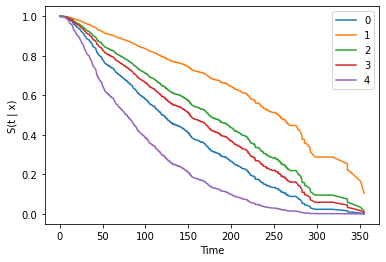

In [43]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [55]:
durations_test[:3]

array([ 69.1     ,  35.633335, 252.96666 ], dtype=float32)

In [56]:
events_test[:3]

array([1, 1, 0], dtype=int32)

In [62]:
np.array(surv.values, order='C')

array([[9.99125083e-01, 9.99709634e-01, 9.99452261e-01, ...,
        9.98454263e-01, 9.99680107e-01, 9.98179117e-01],
       [9.99125083e-01, 9.99709634e-01, 9.99452261e-01, ...,
        9.98454263e-01, 9.99680107e-01, 9.98179117e-01],
       [9.99125083e-01, 9.99709634e-01, 9.99452261e-01, ...,
        9.98454263e-01, 9.99680107e-01, 9.98179117e-01],
       ...,
       [1.04587636e-02, 2.20241972e-01, 5.75842657e-02, ...,
        3.16075487e-04, 1.88829772e-01, 7.51926313e-05],
       [4.45911059e-03, 1.65983110e-01, 3.37721677e-02, ...,
        7.00604199e-05, 1.38274266e-01, 1.27432581e-05],
       [1.08984107e-03, 1.04004399e-01, 1.39814624e-02, ...,
        5.80867228e-06, 8.26194016e-02, 6.77980948e-07]])

In [57]:
surv.iloc[:, :3]

,0,1,2
duration,,,
0.100000,0.999125,0.999710,0.999452
0.766667,0.999125,0.999710,0.999452
1.233333,0.999125,0.999710,0.999452
1.266667,0.999125,0.999710,0.999452
1.433333,0.999125,0.999710,0.999452
...,...,...,...
335.600006,0.016071,0.253978,0.075349
335.733337,0.010459,0.220242,0.057584
337.033325,0.010459,0.220242,0.057584


In [48]:
import pandas as pd
pd.DataFrame(durations_test, events_test)

,0
1,69.099998
1,35.633335
0,252.966660
0,222.199997
1,107.766670
...,...
1,73.833336
1,15.200000
1,46.666668
1,98.699997


In [24]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [60]:
ev

In [59]:
ev.concordance_td()

0.6607052042719105

In [58]:
ev.concordance_td('adj_antolini')

0.6607052042719105

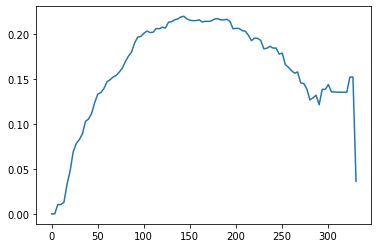

In [26]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [27]:
ev.integrated_brier_score(time_grid)

0.16223513515140095

In [28]:
ev.integrated_nbll(time_grid)

0.4821016544943982